In [3]:
import pandas as pd
data = pd.read_csv(r'C:\Users\iarak\OneDrive\Desktop\PCE\persp-model-econ_w20\ProblemSets\PS7\data\strongdrink.txt')

In [5]:
data.head()

cultivar   alco  malic   ash   alk  magn  tot_phen  flav  nonfl_phen  \
0         1  14.23   1.71  2.43  15.6   127      2.80  3.06        0.28   
1         1  13.20   1.78  2.14  11.2   100      2.65  2.76        0.26   
2         1  13.16   2.36  2.67  18.6   101      2.80  3.24        0.30   
3         1  14.37   1.95  2.50  16.8   113      3.85  3.49        0.24   
4         1  13.24   2.59  2.87  21.0   118      2.80  2.69        0.39   

   proanth  color_int   hue  OD280rat  proline  
0     2.29       5.64  1.04      3.92     1065  
1     1.28       4.38  1.05      3.40     1050  
2     2.81       5.68  1.03      3.17     1185  
3     2.18       7.80  0.86      3.45     1480  
4     1.82       4.32  1.04      2.93      735

In [6]:
y=data["cultivar"]
X=data[["alco","malic","tot_phen","color_int"]]

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=20)
logit = LogisticRegression(random_state = 20, solver = 'lbfgs', 
                           multi_class = 'multinomial').fit(X_train, y_train)

In [9]:
j1 = [logit.intercept_[0]] + logit.coef_[0].tolist()
j2 = [logit.intercept_[1]] + logit.coef_[1].tolist()

In [10]:
pd.DataFrame(data = {'j = 1':j1, 'j = 2':j2}, 
                       index = ['intercept', 'beta1', 'beta2', 'beta3', 'beta4'])

j = 1      j = 2
intercept -24.027617  22.780733
beta1       1.701734  -1.466297
beta2      -0.265788  -0.332951
beta3       1.224101   0.663556
beta4       0.022507  -0.922682

In [11]:
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



In [12]:
import numpy as np
error_rate = (np.array([1,1,1])-np.array([0.87,1,1])).tolist()
pd.DataFrame(data = {'error rate':error_rate}, 
                       index = ['j1', 'j2', 'j3'])

error rate
j1        0.13
j2        0.00
j3        0.00

In [13]:
data['cultivar'].value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

j3 is the group that the model best at predicting. But j2 has the most observations.

In [14]:
MSE_vs = ((y_test - y_pred) ** 2).sum() / y_pred.shape[0]
print('Validation set MSE = ', MSE_vs)

Validation set MSE =  0.045454545454545456


### b

In [15]:
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
Xvars = X.values
yvars = y.values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)

MSE_vec = np.zeros(N_loo)
yt = np.zeros(N_loo)
yp = np.zeros(N_loo)

for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression(random_state = 20, solver = 'lbfgs', 
                                multi_class = 'multinomial')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    yt[test_index] = y_test
    yp[test_index] = y_pred
    if y_test == y_pred:
        MSE_vec[test_index] = 0
    else:
        MSE_vec[test_index] = 1

MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('Test estimate MSE LOOCV =', MSE_loo,
      '\nTest estimate MSE standard error =', MSE_loo_std)

Test estimate MSE LOOCV = 0.07954545454545454 
Test estimate MSE standard error = 0.2705882022679695


In [16]:
print(classification_report(yt, yp))

             precision    recall  f1-score   support

        1.0       0.90      0.93      0.92        59
        2.0       0.91      0.90      0.91        71
        3.0       0.96      0.93      0.95        46

avg / total       0.92      0.92      0.92       176



In [17]:
error_rate_loo = (np.array([1,1,1])-np.array([0.90,0.91,0.96])).tolist()
pd.DataFrame(data = {'error rate':error_rate, 'error rate loo':error_rate_loo}, 
                       index = ['j1', 'j2', 'j3'])

error rate  error rate loo
j1        0.13            0.10
j2        0.00            0.09
j3        0.00            0.04

For j1, the error rate decreases from 0.13 to 0.10.

For j2, the error rate increases from 0.00 to 0.09.

For j3, the error rate increases from 0.00 to 0.04.

### c

In [18]:
k = 4
kf = KFold(n_splits = k, random_state = 10, shuffle = True)
kf.get_n_splits(Xvars)

MSE_vec_kf = np.zeros(k)
yt = np.zeros(N_loo)
yp = np.zeros(N_loo)
k_ind = int(0)

for train_index, test_index in kf.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression(random_state = 20, solver = 'lbfgs', 
                                multi_class = 'multinomial')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    yt[test_index] = y_test
    yp[test_index] = y_pred
    
    mse = []
    for i in range(len(y_test)):
        if y_test[i] == y_pred[i]:
            mse.append(0)
        else:
            mse.append(1)
    MSE_vec_kf[k_ind] = np.array(mse).mean()
    k_ind += 1

In [19]:
MSE_vec_kf = np.array(MSE_vec_kf)
MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('Test estimate MSE k-fold =', MSE_kf)
print('Test estimate MSE standard error =', MSE_kf_std)

Test estimate MSE k-fold = 0.09090909090909091
Test estimate MSE standard error = 0.04821182598999188


In [20]:
print(classification_report(yt, yp))

             precision    recall  f1-score   support

        1.0       0.87      0.93      0.90        59
        2.0       0.91      0.87      0.89        71
        3.0       0.96      0.93      0.95        46

avg / total       0.91      0.91      0.91       176



In [21]:
error_rate_kf = (np.array([1,1,1])-np.array([0.87,0.91,0.96])).tolist()
pd.DataFrame(data = {'error rate':error_rate, 'error rate loo':error_rate_loo,'error rate kf':error_rate_kf}, index = ['j1', 'j2', 'j3'])


error rate  error rate loo  error rate kf
j1        0.13            0.10           0.13
j2        0.00            0.09           0.09
j3        0.00            0.04           0.04

The error rate in k-fold for j1 is the same with that in part(a). And the error rates in k-fold for j2 and j3 are the same with those in part(b).

In [23]:
data2=pd.read_csv(r"C:\Users\iarak\OneDrive\Desktop\PCE\persp-model-econ_w20\ProblemSets\PS7\data\CoolIndex.txt",names=["Age","Cool"])

### 2 a

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
x1 = data2.Age
y1 = data2.Cool
plt.scatter(x1,y1,alpha=0.3)
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against Age")
plt.show()

### b

In [26]:
data2["G1"]=np.where((data2.Age>=11) & (data2.Age<22),1,0)
data2["G2"]=np.where((data2.Age>=22) & (data2.Age<40),1,0)
data2["G3"]=np.where((data2.Age>=40) & (data2.Age<59),1,0)
data2["G4"]=np.where((data2.Age>=59) & (data2.Age<77),1,0)
data2["G5"]=np.where((data2.Age>=77) & (data2.Age<=95),1,0)

In [27]:
import statsmodels.api as sm
x2=data2[["G1","G2","G3","G4","G5"]]
res=sm.OLS(y1,x2).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   Cool   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Fri, 21 Feb 2020   Prob (F-statistic):          3.73e-114
Time:                        21:31:56   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G1            20.1025      0.562     35.746      0.0

In [28]:
res.predict([0,0,0,1,0])

array([35.22540004])

The predicted coolness of a 73-year old is 35.23

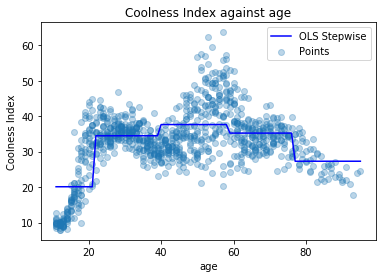

In [30]:
plt.scatter(x1,y1,alpha=0.3,label="Points")
plt.plot(x1,res.predict(),"b",label = "OLS Stepwise")
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()

### c

In [32]:
df=data2.groupby('Age').mean()
df['Age']=df.index

In [33]:
from scipy.interpolate import LSQUnivariateSpline
knots=[22,40,59,77]
ls=LSQUnivariateSpline(np.array(df.Age), np.array(df.Cool), t=knots, k=1)

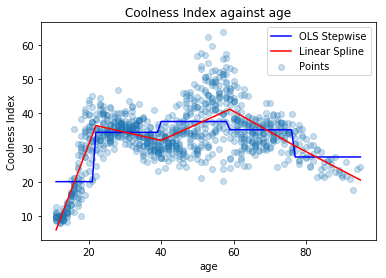

In [34]:
plt.scatter(x1,y1,alpha=0.25,label="Points")
plt.plot(x1,res.predict(),"b",label = "OLS Stepwise")
plt.plot(df.Age,ls(df.Age),"r",label = "Linear Spline")
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()

In [35]:
ls(73)

array(32.86784862)

The predicted coolness of a 73-year old is 32.87

### d

In [36]:
cs=LSQUnivariateSpline(np.array(df.Age), np.array(df.Cool), t=knots, k=3)


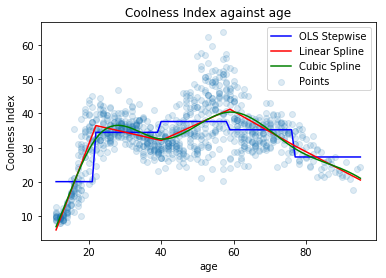

In [37]:
plt.scatter(x1,y1,alpha=0.15,label="Points")
plt.plot(x1,res.predict(),"b",label = "OLS Stepwise")
plt.plot(df.Age,ls(df.Age),"r",label = "Linear Spline")
plt.plot(df.Age,cs(df.Age),"g",label = "Cubic Spline")
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()


In [38]:
cs(73)

array(32.64230107)

The predicted coolness of a 73-year old is 32.64